<font color="#de3023"><h1><b>REMINDER: MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Lab 8: CNNs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request
from google.colab.patches import cv2_imshow

In [ ]:
url = "https://ewscripps.brightspotcdn.com/dims4/default/e666c4b/2147483647/strip/true/crop/1280x720+0+0/resize/1280x720!/quality/90/?url=https%3A%2F%2Fewscripps.brightspotcdn.com%2Fb0%2F82%2Fe97f14ff421ca8ca7d8692e0ecdb%2Fgeneric-1280-1.png"
urllib.request.urlretrieve(url, "bear.png")

('bear.png', <http.client.HTTPMessage at 0x7f0f55930a10>)

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/1/13/Tunnel_View%2C_Yosemite_Valley%2C_Yosemite_NP_-_Diliff.jpg"
urllib.request.urlretrieve(url, "yosemite.png")

('yosemite.png', <http.client.HTTPMessage at 0x7f0f559432d0>)

## CNNs
With that intro done, we now turn to convolutions in deep learning. It turns out that convolutions are *extremely* useful in deep learning applied to computer vision tasks. This is because convolutions can be imagined as being something like a "summary" statistic of a little patch of the input image. This allows for the retention of spatial information as the values propagate through a neural network. The natural question to wonder is: what exactly is getting "learned" in these convolutional layers? After all, for the dense layers, it was the weights of input layers that were being used for the matrix multiply. In the case of convolutional layers, it turns out the learned parameters are the weights in the kernels! So, you initialize the kernels to some value (commonly just zeros or ones), after which they get updated through gradient descent as before. We will see what that gradient is and how you can actually implement such a layer yourself, but let's start with just using CNNs for now.

One aspect of CNNs that may seem a bit bizarre if you've never seen it before is that you can take *multiple* convolutions of the same image. So, instead of having a single kernel that sweeps across the image and produces a single output "convolved image," you may have 10 kernels, each of which sweep across the image and produce a separate convolved image. The reason for this is that it allows different "features" to be learned in the image. We will how to "peer inside" a CNN later, but just imagine these different features as being "some convolutions learn to detect vertical lines, others horizontal lines, and others still corners." These extracted features can then themselves be imagined as an image (after all, your edge detector up above just produced an image as its output!) and they *themselves* be convolved to produce further features. As you combine more and more of these features, the conceptual idea is that you are building up more and more abstract representations of what is present in the image, say working your way up from raw pixels to lines to fur to dogs. 

The result of having these multiple feature maps, however, is that we will now have to keep track of the height, width, *and depth* dimensions in our network. This is typically not much of an issue, but is a bit of bookkeeping you may occasionally find yourself doing: luckily TF makes this quite easy to do. The overall structure of convolutional layers is as shown here:

![](https://www.easy-tensorflow.com/images/NN/img1.png)

Remember that, in the end, we have to actually make predictions across, say, classes in the case of MNIST or other classification tasks. So, the final layers of a neural network will almost always be some collection of fully connected (or `tf.Dense` in TF speak) layers. 

The only part of the above diagram that's likely completely new to you is the "pooling" layers. These layers serve to just extract subsets of the convolution operations. Remember, the idea behind convolutions is to take the raw image and to summarize different regions of that image. However, the output of a convolution (as you saw in your implemented above) is pretty much the same size as the input image (with the exception of the boundary), neighboring pixels in the convolved image containing roughly the same "information." The idea of pooling is to reduce this redundancy and "compress" the information into a more abstract representation than raw pixels. All pooling does is select a single pixel from a region of interest. The two types of pooling used in practice are MaxPooling and AveragePooling. The accuracy differences between the choice of these two are often minimal, so we will just stick with MaxPooling in this class. MaxPool works as shown in this animation:

![](https://www.oreilly.com/radar/wp-content/uploads/sites/3/2019/06/Figure_4-87c227113cdd0b73d842267404d4aa00.gif)

We will now see how to do this in TF, after which we will crack open the hood to see how these operations are implemented from scratch. One common task on images is to do classification, so we will be doing that to begin with here. 

**NOTE**: One **important** detail is that, when dealing with images, you must normalize them when using CNNs. This is not strictly necessary, but it seems to speed up training in practice.

170498071/170498071 [==============================] - 3s 0us/step


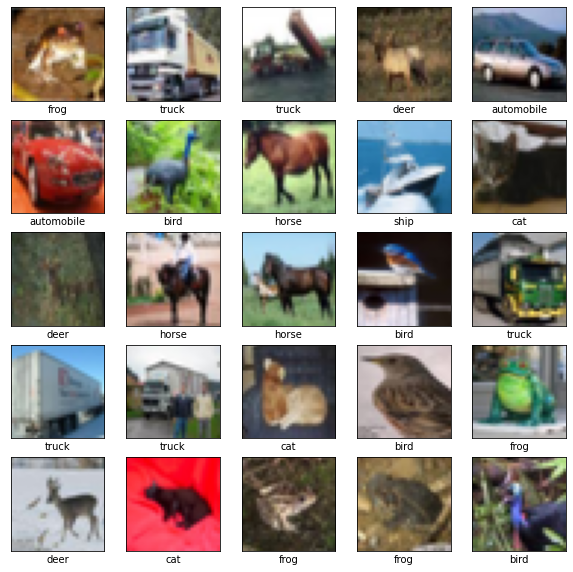

In [ ]:
# taken from TF tuturial: https://www.tensorflow.org/tutorials/images/cnn
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
#############################################################################
# Exercise                                                        #
# Using a basic network (no convolutional layers), do classification on     #
# CIFAR-10. You are allowed to use any of the layers discussed in the past  #
# HW assignment (Dense, Dropout, BatchNorm). Your code should contain these:#
#                                                                           #
# 1) Define a model (for simplicity, just use the tf.keras.models.Sequential#
# interface) with Dense, Dropout, or BatchNorm layers. The first layer MUST #
# be a tf.keras.layers.Flatten() layer, otherwise you will get errors. Also,# 
# remember that we are classifying into 10 classes: choose sizes to fit.    #
#                                                                           #
# 2) Run the appropriate fit function. Remember, here we are doing          #
# classification, so you must use the appropriate loss function. You must   #
# achieve a test accuracy of at least .25.                                  # 
#############################################################################
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=3)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/3
1563/1563 [==============================] - 12s 7ms/step - loss: 2.0977 - accuracy: 0.2065
Epoch 2/3
1563/1563 [==============================] - 11s 7ms/step - loss: 2.0391 - accuracy: 0.2334
Epoch 3/3
1563/1563 [==============================] - 11s 7ms/step - loss: 2.0190 - accuracy: 0.2425
313/313 - 1s - loss: 1.9220 - accuracy: 0.3188 - 1s/epoch - 3ms/step
Test accuracy: 0.3188000023365021


You likely got fairly poor results from the basic network structure in the above task. If you got even close to 40% accuracy, that is remarkable. However, we will see that, using convolutional layers, it becomes remarkably easier to get such accuracies and better. As mentioned, the structure of such networks is simply alternating between convolutional and pooling layers, finally followed by the FC structures you know so far. As mentioned, you will likely want multiple features per convolutions you perform.

In [ ]:
#############################################################################
# Exercise                                                         #
# Now using a CNN network (*with* convolutional layers), do classification  #
# on CIFAR-10. You are still allowed to use any of the layers discussed     #
# before (Dense, Dropout, BatchNorm). Your code should contain these:       #
#                                                                           #
# Define a model (for simplicity, just use the tf.keras.models.Sequential   #
# interface), now with Conv2D and MaxPool. You MUST have at least 2 Conv2D. #
# and MaxPooling2D layers each. Achieve a test accuracy of at least .70.    #
#                                                                           #
# Note: whenver you go from doing convolutions/pooling to dense layers, you #
# MUST flatten the tensor. So, you will have a Flatten layer between the    #
# Conv2D/MaxPool and Dense layers.                                          #
#############################################################################

# Replace "pass" statement with your code and store the resulting network as a
# variable called "model"

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=3)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/3
1563/1563 [==============================] - 82s 52ms/step - loss: 1.5615 - accuracy: 0.4282
Epoch 2/3
1563/1563 [==============================] - 86s 55ms/step - loss: 1.2124 - accuracy: 0.5713
Epoch 3/3
1563/1563 [==============================] - 79s 51ms/step - loss: 1.0564 - accuracy: 0.6291
313/313 - 6s - loss: 1.0180 - accuracy: 0.6448 - 6s/epoch - 19ms/step
Test accuracy: 0.6448000073432922


### Data Augmentation
One of the principal ways people in practice make do with limited data is reusing it in creative ways. This is not often used outside the context of images; however, it plays a large role in computer vision. The idea behind data augmentation is to take the original data and perturb it in ways that we know do not change the association with the label of that data. For example, if we have an image of a dog, we can rotate or flip that image horizontally and directly generate a "new" image of a dog that did not previously exist. There are a number of more creative ways of doing such augmentation shown below.

![](https://miro.medium.com/max/1400/1*ae1tW5ngf1zhPRyh7aaM1Q.png)

Let's give augmentation a try in CIFAR and retrain the network with this augmented dataset. The performance will likely be around the same on the training set: the idea behind augmentation is to account for cases that were *not* captured in the training set that we may encounter at test time. We'll start with using some of the ones that TF provides followed by creating one of our own.

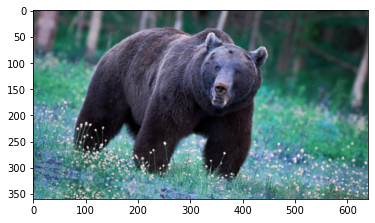

In [ ]:
# from: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

bear = cv2.imread("bear.png") / 255
bear = cv2.resize(bear, None, fx=0.5, fy=0.5)
augmented_bear = data_augmentation(bear)
plt.imshow(augmented_bear)

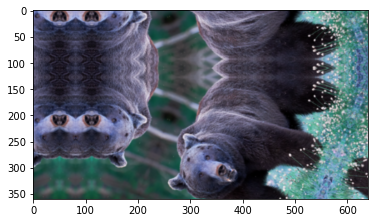

In [ ]:
from tensorflow.keras import Model

(train_images, train_labels), _ = datasets.cifar10.load_data()

#############################################################################
# Exercise                                                        #
# Follow the documentation on https://www.tensorflow.org/tutorials/images/data_augmentation
# to construct another data augmentation pipelines for the bear image 
#############################################################################

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.5),
  layers.RandomZoom(.2),
  layers.RandomTranslation(0.6, 0.3),
])
augmented_bear = data_augmentation(bear)
plt.imshow(augmented_bear)

# #############################################################################
# #                              END OF YOUR CODE                             #
# #############################################################################

## Transfer Learning
In the real world, one event that comes up frequently is where a network was trained for a particular task and there later arises a need to perform a similar but distinct task. For instance, suppose we train a network to classify whether an image is a cat or dog and later wish to do classification between cats and wolves. The naive thing thing to do would be to simply train another network to do this separate classification task. But there are a couple potential problems in going ahead with this direct approach. 

The two biggest ones are that, when you are training networks in the real world, often these models will be *enormous*, meaning training could take on the order of days or even weeks. Having to retrain a model for such a small change is then simply a waste of precious time. The second main reason is that many times the new task does not have enough data to realistically train a network from scratch. In both cases, the goal is to use use the initial network to "bootstrap" and then use the perhaps small specific dataset to refine it for the new task.

*Transfer Learning* is the idea of *re-using* a pre-trained model for a new task. Beyond the computational and sample efficiency benefits of re-using a pre-trained model, transfer learning is an intuitive strategy: it enables knowledge (i.e. useful high-dimensional representations of input images) to be shared/transfered across different tasks. 

![](https://raminnabati.com/post/003_adv_pytorch_modifying_the_last_layer/featured_hu6b7efa1ee5af0373ed99550e7733a81e_203192_720x0_resize_lanczos_2.png)


There are two main strategies to transfer learning: (1) Feaure Extracting and (2) Fine-Tuning. In the Feature Extracting approach, we freeze the weights of a large pre-trained model and use it as a Feature Extractor. We then train a *small neural network head* that takes as input the features output by our frozen pre-trained model and outputs the scores for each class. Critically, in this approach, only the weights of the *head* are updated during backpropogation.

In the Fine Tuning approach, we also add a *small neural network head* to the end of our pre-trained model, however, the weights of the pre-trained model are NOT frozen now. That is, both the weights of classification head AND the pre-trained model get updated during backpropagation. This method is called Fine Tuning precisely because we are Fine Tuning the weights of our pre-trained model for our new task. Note that compared to the Feature Extractor approach, Fine Tuning is significantly more computationally expensive due to the fact that all weights are being updated (as opposed to just the classification head). 


![](https://pyimagesearch.com/wp-content/uploads/2019/06/fine_tuning_keras_freeze_unfreeze.png)

The image above provides a nice visualization of the differences between the Fine Tuning (right) approach and the Feature Extraction (left) approach. Let's see how this works in practice. To get started, we will use one of TF's pre-trained networks. Being able to use these networks is another key skill in building modern networks: there are a ton of resources that have gone into training these, which allows you to bypass such a time sink and more directly get to experimenting. Pre-trained networks are stored in `tensorflow_hub`:

In [ ]:
import tensorflow_hub as hub

Let's try using one of these networks for a task. Inception is an incredibly large network that has been trained for image classification. Let's try it out in its basic form and then see how to extend it for the purposes of other classification:

![](https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png)

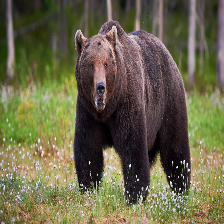

10484/10484 [==============================] - 0s 0us/step
Predicted class: brown bear


In [ ]:
model = None
#############################################################################
# Exercise
# Follow the guide on the TF transfer learning page to load the Inception   #
# network: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#an_imagenet_classifier
# Assign the loaded network to a variable called "model" so that it does    #
# a prediction on our bear image per the code below. Assume inputs will be  #
# the size they are in ImageNet (224, 224). You should use the Sequential   #
# model in Keras.                                                           #
#############################################################################
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
model = tf.keras.Sequential([
    hub.KerasLayer(inception_v3, input_shape=(224, 224)+(3,))
])
#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

bear = cv2.imread("bear.png")
bear = cv2.resize(bear, (224, 224))
cv2_imshow(bear)

bear = bear / 255.0
result = model.predict(bear[np.newaxis, ...])
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[tf.math.argmax(result[0], axis=-1)]
print(f"Predicted class: {predicted_class_name}")

You should now see the magic of such frozen models: without doing *any* training, you are able to do the tasks that are likely of interest, in this case, classifying images. The issue, of course, is that we only have a limited number of classes. ImageNet, as good a dataset as it is, is limited to a number of labels that its curators decided were worthwhile keeping. We see that ImageNet, in this incarnation, has 1001 class labels. So, if we want to classify something that is outside the scope of those 1001 classes, we are out of luck... unless we use transfer learning!

Our task is now to distinguish between ants and bees. These two classes are subsets of ImageNet, but we want to avoid spurious classifications into other classes outside of these two. Let's start by downloading the data:

In [ ]:
import zipfile

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
urllib.request.urlretrieve(url, "hymenoptera_data.zip")

with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

train_ds = tf.keras.utils.image_dataset_from_directory("hymenoptera_data/train")
val_ds   = tf.keras.utils.image_dataset_from_directory("hymenoptera_data/val")

Found 245 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


In [ ]:
#############################################################################
# Exercise                                                  #
# Follow the guide on the TF transfer learning page to perform transfer     #
# learning using the Inception onto the ants/bees dataset.                  #
# https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#an_imagenet_classifier
#                                                                           #
# 1) Construct the extension of the model to do prediction appropriately for#
# the ants/bees dataset                                                     #
#                                                                           #
# 2) Compile and fit your model                                             #
#############################################################################

inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
model = tf.keras.Sequential([
    hub.KerasLayer(inception_v3, trainable=False),
    tf.keras.layers.Dense(2)
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

Epoch 1/10
8/8 [==============================] - 66s 8s/step - loss: 20.2500 - acc: 0.5102 - val_loss: 11.9515 - val_acc: 0.5294
Epoch 2/10
8/8 [==============================] - 58s 7s/step - loss: 14.0194 - acc: 0.5592 - val_loss: 11.7950 - val_acc: 0.5098
Epoch 3/10
8/8 [==============================] - 59s 8s/step - loss: 8.9805 - acc: 0.6245 - val_loss: 14.2891 - val_acc: 0.5163
Epoch 4/10
8/8 [==============================] - 59s 8s/step - loss: 7.8947 - acc: 0.6245 - val_loss: 14.3455 - val_acc: 0.5098
Epoch 5/10
8/8 [==============================] - 58s 8s/step - loss: 7.8292 - acc: 0.6653 - val_loss: 10.2778 - val_acc: 0.5621
Epoch 6/10
8/8 [==============================] - 61s 8s/step - loss: 5.9454 - acc: 0.6653 - val_loss: 10.4555 - val_acc: 0.5033
Epoch 7/10
8/8 [==============================] - 58s 7s/step - loss: 6.2552 - acc: 0.6490 - val_loss: 9.8979 - val_acc: 0.5098
Epoch 8/10
8/8 [==============================] - 58s 7s/step - loss: 4.9509 - acc: 0.6776 - val

## Style Transfer
Aside from being useful in speeding up training time, freezing and reusing networks can be useful for other tasks, such as style transfer! One very different aspect of style transfer compared to all the other networks we've looked at so far is that there's no ground truth! So, the notion of a loss function seems a bit mysterious. In fact, even what the input is seems a bit unclear!

Style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [VGG19](https://keras.io/api/applications/vgg/), a large model that has been trained on ImageNet.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](http://web.eecs.umich.edu/~justincj/teaching/eecs498/example_styletransfer.png)

Let's talk about this conceptually: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf (slides 49-70)

## Conceptual Takeaways
So, style transfer is very weird in terms of the networks we've seen so far! In all other tasks, we have fixed inputs (and outputs) and are using the loss function to update the network. Here, we are **fixing** the network and using the loss function to update the **input**! The remarkable thing is that automated gradients allow for this flexibility. As a recap of the above slides:

- Input: Trainable image (initialize to be random)
- Loss: Content + Style losses (fixed layers from VGG). Remember the desired content/style outputs are **FIXED**

We're not going to build the full thing here, but let's see how you might get started with this! Let's start by just grabbing a model with the layers of interest:

In [ ]:
content_layers = ['block4_conv3'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

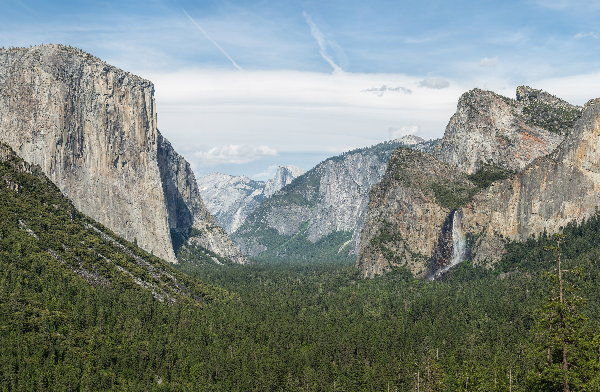

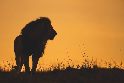

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request
from google.colab.patches import cv2_imshow

def get_img_from_url(url):
  urllib.request.urlretrieve(url, "tmp.png")
  img = cv2.imread("tmp.png")
  img = cv2.resize(img, None, fx=0.10, fy=0.10)
  cv2_imshow(img)
  img = np.expand_dims(img, axis=0) / 255.0

  return img

style_img = get_img_from_url("https://upload.wikimedia.org/wikipedia/commons/1/13/Tunnel_View%2C_Yosemite_Valley%2C_Yosemite_NP_-_Diliff.jpg")
content_img = get_img_from_url("https://images.immediate.co.uk/production/volatile/sites/23/2021/06/Scarface-silhouette.-Jonathan-and-Angela-Scott-780dafb.jpg?webp=true&quality=45&resize=1240%2C826")

In [ ]:
style_extractor = vgg_layers(style_layers)

#############################################################################
# Exercise                                                             #
# Pass the img through style_extractor. How many outputs do you
# get from the network?
#############################################################################

output = style_extractor(style_img)
print(len(output))

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

80134624/80134624 [==============================] - 2s 0us/step
4


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

#############################################################################
# Exercise                                                              #
# Pass the style_image through extractor. What type is the output(s) of the model
# now compared to the style_extactor?
#############################################################################

style_content = extractor(style_img)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

Let's take a look inside the results output. You'll need to use something like this for constructing the loss:

In [ ]:
#############################################################################
# Exercise                                                              #
# Iterate through the content of the results dict and print the shape. Do
# the same for the style. What do these dimensions mean again?
#############################################################################
style_content = extractor(style_img)
style_dict = style_content["style"]
for key in style_dict.keys():
  print(type(style_dict[key]))
  print(style_dict[key].shape)
#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 392, 600, 64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 196, 300, 128)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 98, 150, 256)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 49, 75, 512)


In [ ]:
#############################################################################
# Exercise                                                              #
# Define the style_output and content_output using the Extractor network
# using the correct images
#############################################################################
style_output = extractor(style_img)["style"]
content_output = extractor(content_img)["content"]

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

In [ ]:
our_image = tf.Variable(tf.ones(content_img.shape))

#############################################################################
# Exercise                                                              #
# Create a "loss" variable that is the sum of the square difference between
# the content of the desired output and the image we are working with
#############################################################################

our_content = extractor(our_image)["content"]
loss = tf.math.reduce_sum((content_output[content_layers[0]] - our_content[content_layers[0]]) ** 2)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

print(loss)

tf.Tensor(20994744000.0, shape=(), dtype=float32)
